### TRAINING DATASET

In [1]:
import numpy as np
import pandas as pd
from numpy import trapezoid

# Define parameter ranges
epsilon_vals = np.linspace(0.05, 0.50, 100)
cos_phi_vals = np.linspace(0.75, 1.00, 10)
delta_vals = np.linspace(0.05, 0.15, 10)
tau_s = 0.05
cos_phi_s = 0.5

# Time domain
tau = np.linspace(0, 1, 5000)

# Speed profiles
def r_sin(tau, epsilon, n=1):
    return 1 - epsilon * np.sin(n * np.pi * tau)**2

def r_tanh(tau, epsilon, k=10):
    return 1 - epsilon * (1 - np.tanh(k * (tau - 0.5))**2)

# Energy function
def f_r(r_hat, delta, cos_phi_r):
    return r_hat**3 * (cos_phi_r - delta * (1 - r_hat))

# Energy ratio computation
def compute_all_energy_ratios(r_hat, delta, cos_phi_r, tau_s=0.05, cos_phi_s=0.5):
    e = trapezoid(f_r(r_hat, delta, cos_phi_r), tau) / cos_phi_r
    e_main = trapezoid(f_r(r_hat[tau >= tau_s], delta, cos_phi_r), tau[tau >= tau_s])
    e_soft = tau_s * (cos_phi_s / 4 + (cos_phi_r - cos_phi_s) / 5)
    e_s = (1 / cos_phi_r) * (e_soft + (1 - tau_s) * e_main)
    e_s_ratio = tau_s * (e_soft / e) + (1 - tau_s) * (e_main / trapezoid(f_r(r_hat, delta, cos_phi_r), tau))
    e_s0 = (tau_s / cos_phi_r) * (cos_phi_s / 4 + (cos_phi_r - cos_phi_s) / 5) + (1 - tau_s)**2
    return [e, e_s, e_s_ratio, e_s0]

# === Separate data lists ===
data_sin = []
data_tanh = []

# Generate data
for eps in epsilon_vals:
    for cos_phi in cos_phi_vals:
        for dlt in delta_vals:
            # Sinusoidal profile
            rhat_sin = r_sin(tau, eps)
            outputs_sin = compute_all_energy_ratios(rhat_sin, dlt, cos_phi, tau_s, cos_phi_s)
            data_sin.append([eps, cos_phi, dlt] + outputs_sin)

            # Tanh profile
            rhat_tanh = r_tanh(tau, eps)
            outputs_tanh = compute_all_energy_ratios(rhat_tanh, dlt, cos_phi, tau_s, cos_phi_s)
            data_tanh.append([eps, cos_phi, dlt] + outputs_tanh)

# Save to separate CSVs
columns = ['epsilon', 'cos_phi_r', 'delta', 'E_E0', 'Es_E0', 'Es_E', 'Es0_E0']
pd.DataFrame(data_sin, columns=columns).to_csv("pinn_data_sin.csv", index=False)
pd.DataFrame(data_tanh, columns=columns).to_csv("pinn_data_tanh.csv", index=False)

# === Print Dataset Information ===
print("\n✅ Data Generation Summary:")
print(f"Number of epsilon points: {len(epsilon_vals)}")
print(f"Number of cos_phi_r points: {len(cos_phi_vals)}")
print(f"Number of delta points: {len(delta_vals)}")
print(f"Total number of samples per dataset: {len(data_sin)}")
print(f"Number of features (input): 3")
print(f"Number of targets (output): 4")
print(f"Generated files: 'pinn_data_sin.csv' and 'pinn_data_tanh.csv'")

# Show example ranges
print("\nExample epsilon range:", f"[{epsilon_vals.min():.2f}, {epsilon_vals.max():.2f}]")
print("Example cos_phi_r range:", f"[{cos_phi_vals.min():.2f}, {cos_phi_vals.max():.2f}]")
print("Example delta range:", f"[{delta_vals.min():.2f}, {delta_vals.max():.2f}]")


✅ Data Generation Summary:
Number of epsilon points: 100
Number of cos_phi_r points: 10
Number of delta points: 10
Total number of samples per dataset: 10000
Number of features (input): 3
Number of targets (output): 4
Generated files: 'pinn_data_sin.csv' and 'pinn_data_tanh.csv'

Example epsilon range: [0.05, 0.50]
Example cos_phi_r range: [0.75, 1.00]
Example delta range: [0.05, 0.15]


### PREDICTION MODEL 1

Epoch 0 | Train Loss: 5.607619 | Val Loss: 4.922377 | Val MAE: 0.667327
Epoch 500 | Train Loss: 0.018704 | Val Loss: 0.000702 | Val MAE: 0.011342
Epoch 1000 | Train Loss: 0.013291 | Val Loss: 0.000582 | Val MAE: 0.010752
Epoch 1500 | Train Loss: 0.009863 | Val Loss: 0.000453 | Val MAE: 0.009681
Epoch 2000 | Train Loss: 0.007647 | Val Loss: 0.000314 | Val MAE: 0.008568
Epoch 2500 | Train Loss: 0.006388 | Val Loss: 0.000197 | Val MAE: 0.007479
Epoch 3000 | Train Loss: 0.004943 | Val Loss: 0.000132 | Val MAE: 0.006601
Epoch 3500 | Train Loss: 0.004240 | Val Loss: 0.000097 | Val MAE: 0.005709
Epoch 4000 | Train Loss: 0.003796 | Val Loss: 0.000083 | Val MAE: 0.005323
Epoch 4500 | Train Loss: 0.003343 | Val Loss: 0.000079 | Val MAE: 0.004948


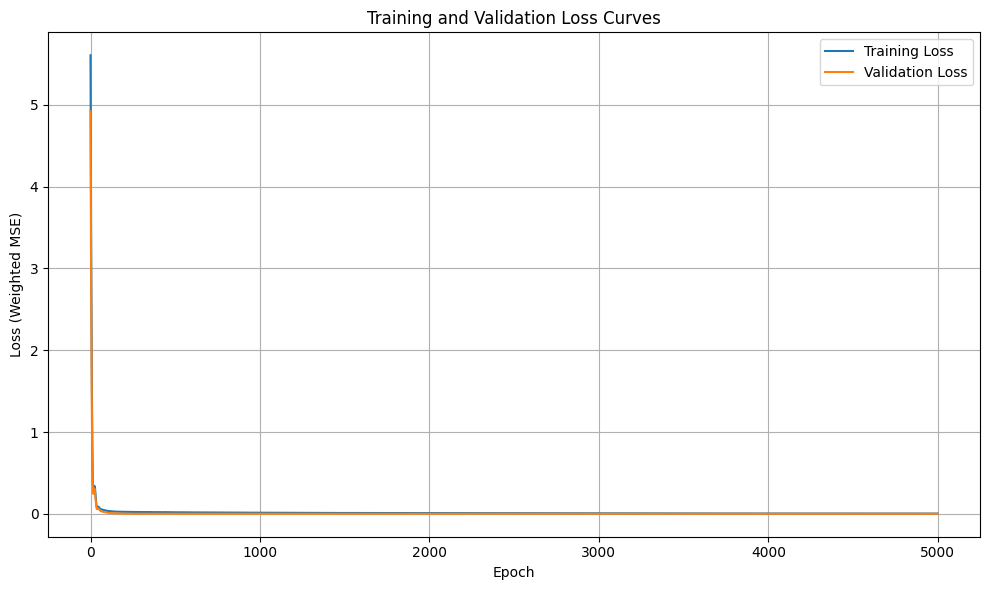

✅ Model training completed. Best model saved as 'trained_model1.pth'


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib
import os

torch.manual_seed(42)
np.random.seed(42)
df = pd.read_csv(r'F:\786\Projects\Project 9 - Energy Optimization\Figures\figure3\pinn_data_sin.csv')
X = df[['epsilon', 'cos_phi_r', 'delta']].values
y = df[['E_E0', 'Es_E0', 'Es_E', 'Es0_E0']].values
x_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

class EnergyModel(nn.Module):
    def __init__(self):
        super(EnergyModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 48),
            nn.Tanh(),
            nn.Dropout(0.05),
            nn.Linear(48, 48),
            nn.Tanh(),
            nn.Dropout(0.05),
            nn.Linear(48, 4)
        )

    def forward(self, x):
        return self.net(x)

model = EnergyModel()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, preds, targets):
        loss = (self.weights * (preds - targets)**2).mean()
        return loss

loss_weights = torch.tensor([1.0, 1.0, 2.0, 20.0])
criterion = WeightedMSELoss(loss_weights)
n_epochs = 5000
patience = 300
best_val_loss = np.inf
counter = 0
loss_train_list = []
loss_val_list = []

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train_tensor)
    loss_train = criterion(preds, y_train_tensor)
    loss_train.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        preds_val = model(X_val_tensor)
        loss_val = criterion(preds_val, y_val_tensor)

    loss_train_list.append(loss_train.item())
    loss_val_list.append(loss_val.item())
    if loss_val.item() < best_val_loss:
        best_val_loss = loss_val.item()
        counter = 0
        torch.save(model.state_dict(), 'trained_model1.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    if epoch % 500 == 0:
        mae = torch.mean(torch.abs(preds_val - y_val_tensor)).item()
        print(f"Epoch {epoch} | Train Loss: {loss_train.item():.6f} | Val Loss: {loss_val.item():.6f} | Val MAE: {mae:.6f}")

joblib.dump(x_scaler, 'scaler1.pkl')
plt.figure(figsize=(10,6))
plt.plot(loss_train_list, label='Training Loss')
plt.plot(loss_val_list, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (Weighted MSE)")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("✅ Model training completed. Best model saved as 'trained_model1.pth'")

### PLOTTING 1

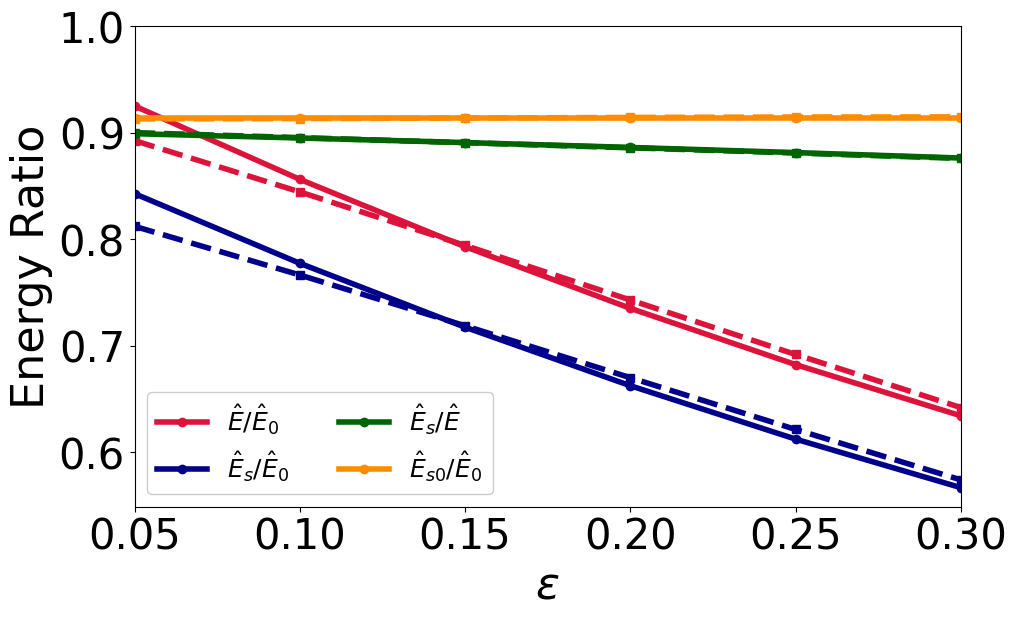

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import joblib

class EnergyModel(torch.nn.Module):
    def __init__(self):
        super(EnergyModel, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(3, 48),
            torch.nn.Tanh(),
            torch.nn.Dropout(0.05),
            torch.nn.Linear(48, 48),
            torch.nn.Tanh(),
            torch.nn.Dropout(0.05),
            torch.nn.Linear(48, 4)
        )
    def forward(self, x):
        return self.net(x)
model = EnergyModel()
model.load_state_dict(torch.load(r'F:\786\Projects\Project 9 - Energy Optimization\Figures\figure3\trained_model1.pth'))
model.eval()
x_scaler = joblib.load(r'F:\786\Projects\Project 9 - Energy Optimization\Figures\figure3\scaler1.pkl')
cos_phi_r = 0.85
delta = 0.1
epsilons = np.linspace(0.05, 0.30, 6)
tau = np.linspace(0, 1, 500)
tau_s = 0.05
cos_phi_s = 0.5

def r_sin(tau, epsilon):
    return 1 - epsilon * np.sin(np.pi * tau)**2

def f_r(r_hat, delta, cos_phi_r):
    return r_hat**3 * (cos_phi_r - delta * (1 - r_hat))

def compute_energy_ratios(r_hat, delta, cos_phi_r, tau_s=0.05, cos_phi_s=0.5):
    from numpy import trapezoid
    e_total = trapezoid(f_r(r_hat, delta, cos_phi_r), tau) / cos_phi_r
    e_main = trapezoid(f_r(r_hat[tau >= tau_s], delta, cos_phi_r), tau[tau >= tau_s])
    e_soft = tau_s * (cos_phi_s / 4 + (cos_phi_r - cos_phi_s) / 5)
    e_s = (1 / cos_phi_r) * (e_soft + (1 - tau_s) * e_main)
    e_s_ratio = tau_s * (e_soft / e_total) + (1 - tau_s) * (e_main / trapezoid(f_r(r_hat, delta, cos_phi_r), tau))
    e_s0 = (tau_s / cos_phi_r) * (cos_phi_s / 4 + (cos_phi_r - cos_phi_s) / 5) + (1 - tau_s)**2
    return [e_total, e_s, e_s_ratio, e_s0]

predicted_all = []
exact_sin_all = []
for epsilon in epsilons:
    x_input = np.array([[epsilon, cos_phi_r, delta]])
    x_scaled = x_scaler.transform(x_input)
    x_tensor = torch.tensor(x_scaled, dtype=torch.float32)
    with torch.no_grad():
        y_pred = model(x_tensor).numpy().flatten()
    predicted_all.append(y_pred)
    rhat = r_sin(tau, epsilon)
    exact_sin_all.append(compute_energy_ratios(rhat, delta, cos_phi_r))
predicted_all = np.array(predicted_all)
exact_sin_all = np.array(exact_sin_all)

plt.figure(figsize=(10, 6))
labels = [r'$\hat{E}/\hat{E}_0$', r'$\hat{E}_s/\hat{E}_0$', r'$\hat{E}_s/\hat{E}$', r'$\hat{E}_{s0}/\hat{E}_0$']
colors = ['crimson', 'darkblue', 'darkgreen', 'darkorange']
for i in range(4):
    plt.plot(epsilons, exact_sin_all[:, i], color=colors[i], linestyle='-', marker='o', linewidth=4, label=labels[i])
    plt.plot(epsilons, predicted_all[:, i], color=colors[i], linestyle='--', marker='s', linewidth=4)
plt.xlabel('$\\epsilon$', fontsize=32)
plt.ylabel('Energy Ratio', fontsize=32)
xticks = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
plt.xticks(ticks=xticks, fontsize=30)
plt.xlim(0.05, 0.30)
yticks = [0.6, 0.7, 0.8, 0.9, 1.0]
plt.yticks(ticks=yticks, fontsize=30)
plt.legend(fontsize=18, loc='lower left', framealpha=1.0, ncol=2)
plt.tight_layout(pad=0.1)
plt.savefig('figure31.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.savefig('figure31.png', format='png', dpi=1200, bbox_inches='tight')
plt.show()

### PREDICTION MODEL 2

Epoch 0 | Train Loss: 5.729993 | Val Loss: 5.042936 | Val MAE: 0.764183
Epoch 500 | Train Loss: 0.018894 | Val Loss: 0.000600 | Val MAE: 0.008955
Epoch 1000 | Train Loss: 0.013382 | Val Loss: 0.000464 | Val MAE: 0.007577
Epoch 1500 | Train Loss: 0.009921 | Val Loss: 0.000342 | Val MAE: 0.006581
Epoch 2000 | Train Loss: 0.007656 | Val Loss: 0.000219 | Val MAE: 0.005603
Epoch 2500 | Train Loss: 0.006357 | Val Loss: 0.000119 | Val MAE: 0.004582
Epoch 3000 | Train Loss: 0.004904 | Val Loss: 0.000057 | Val MAE: 0.003743
Epoch 3500 | Train Loss: 0.004081 | Val Loss: 0.000032 | Val MAE: 0.003037
Epoch 4000 | Train Loss: 0.003620 | Val Loss: 0.000023 | Val MAE: 0.002852
Epoch 4500 | Train Loss: 0.003165 | Val Loss: 0.000027 | Val MAE: 0.002764


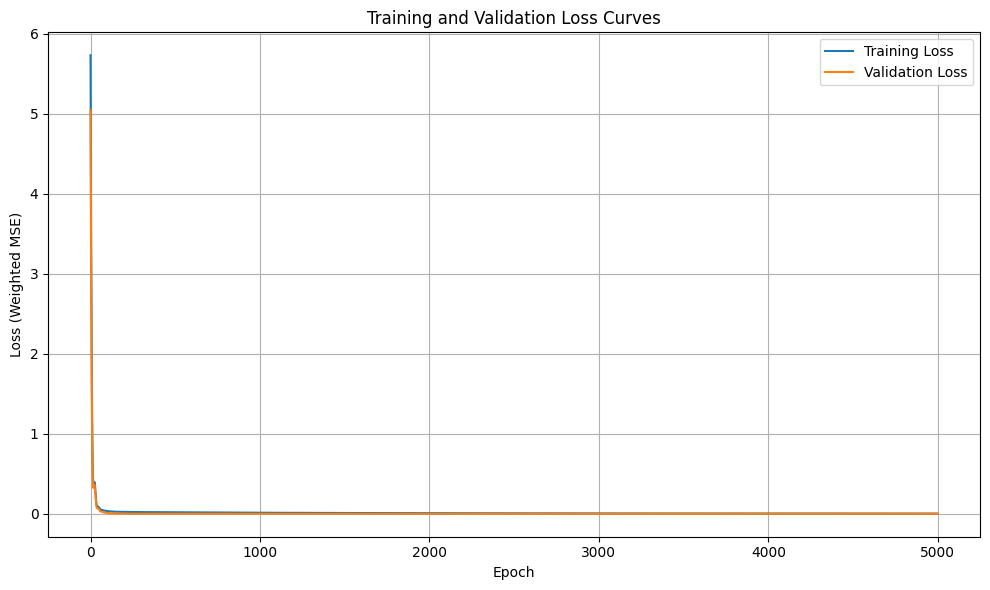

✅ Model training completed. Best model saved as 'trained_model2.pth'


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib
import os

torch.manual_seed(42)
np.random.seed(42)
df = pd.read_csv(r'F:\786\Projects\Project 9 - Energy Optimization\Figures\figure3\pinn_data_tanh.csv')
X = df[['epsilon', 'cos_phi_r', 'delta']].values
y = df[['E_E0', 'Es_E0', 'Es_E', 'Es0_E0']].values
x_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

class EnergyModel(nn.Module):
    def __init__(self):
        super(EnergyModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 48),
            nn.Tanh(),
            nn.Dropout(0.05),
            nn.Linear(48, 48),
            nn.Tanh(),
            nn.Dropout(0.05),
            nn.Linear(48, 4)
        )

    def forward(self, x):
        return self.net(x)

model = EnergyModel()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, preds, targets):
        loss = (self.weights * (preds - targets)**2).mean()
        return loss

loss_weights = torch.tensor([1.0, 1.0, 2.0, 20.0])
criterion = WeightedMSELoss(loss_weights)
n_epochs = 5000
patience = 300
best_val_loss = np.inf
counter = 0
loss_train_list = []
loss_val_list = []

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train_tensor)
    loss_train = criterion(preds, y_train_tensor)
    loss_train.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        preds_val = model(X_val_tensor)
        loss_val = criterion(preds_val, y_val_tensor)

    loss_train_list.append(loss_train.item())
    loss_val_list.append(loss_val.item())
    if loss_val.item() < best_val_loss:
        best_val_loss = loss_val.item()
        counter = 0
        torch.save(model.state_dict(), 'trained_model2.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    if epoch % 500 == 0:
        mae = torch.mean(torch.abs(preds_val - y_val_tensor)).item()
        print(f"Epoch {epoch} | Train Loss: {loss_train.item():.6f} | Val Loss: {loss_val.item():.6f} | Val MAE: {mae:.6f}")

joblib.dump(x_scaler, 'scaler2.pkl')
plt.figure(figsize=(10,6))
plt.plot(loss_train_list, label='Training Loss')
plt.plot(loss_val_list, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (Weighted MSE)")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("✅ Model training completed. Best model saved as 'trained_model2.pth'")

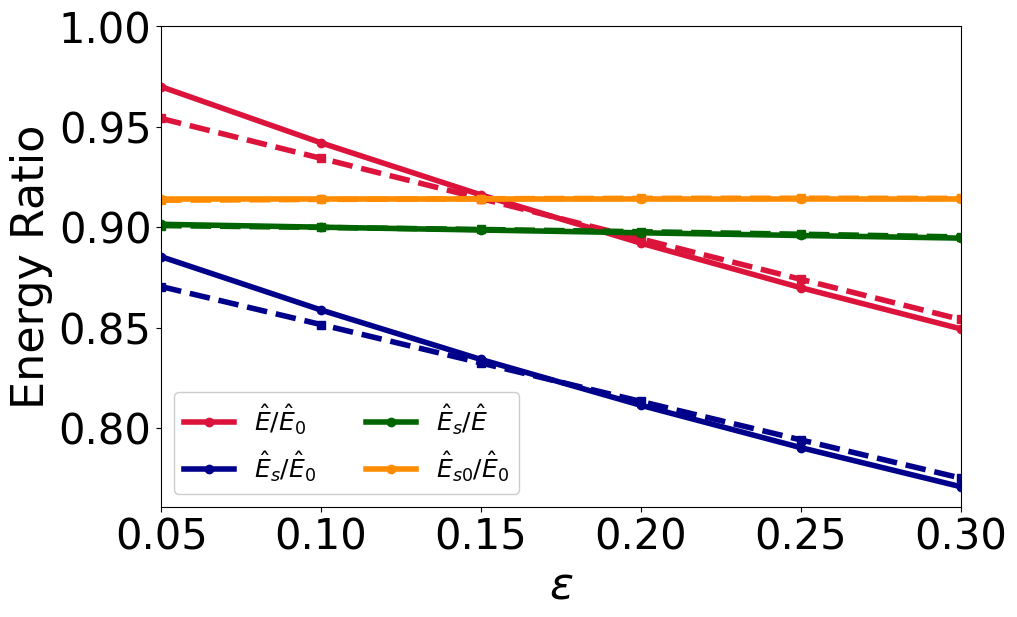

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import joblib

class EnergyModel(torch.nn.Module):
    def __init__(self):
        super(EnergyModel, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(3, 48),
            torch.nn.Tanh(),
            torch.nn.Dropout(0.05),
            torch.nn.Linear(48, 48),
            torch.nn.Tanh(),
            torch.nn.Dropout(0.05),
            torch.nn.Linear(48, 4)
        )
    def forward(self, x):
        return self.net(x)
model = EnergyModel()
model.load_state_dict(torch.load(r'F:\786\Projects\Project 9 - Energy Optimization\Figures\figure3\trained_model2.pth'))
model.eval()
x_scaler = joblib.load(r'F:\786\Projects\Project 9 - Energy Optimization\Figures\figure3\scaler2.pkl')
cos_phi_r = 0.85
delta = 0.1
epsilons = np.linspace(0.05, 0.30, 6)
tau = np.linspace(0, 1, 500)
tau_s = 0.05
cos_phi_s = 0.5

def r_tanh(tau, epsilon):
    return 1 - epsilon * (1 - np.tanh(10 * (tau - 0.5))**2)

def f_r(r_hat, delta, cos_phi_r):
    return r_hat**3 * (cos_phi_r - delta * (1 - r_hat))

def compute_energy_ratios(r_hat, delta, cos_phi_r, tau_s=0.05, cos_phi_s=0.5):
    from numpy import trapezoid
    e_total = trapezoid(f_r(r_hat, delta, cos_phi_r), tau) / cos_phi_r
    e_main = trapezoid(f_r(r_hat[tau >= tau_s], delta, cos_phi_r), tau[tau >= tau_s])
    e_soft = tau_s * (cos_phi_s / 4 + (cos_phi_r - cos_phi_s) / 5)
    e_s = (1 / cos_phi_r) * (e_soft + (1 - tau_s) * e_main)
    e_s_ratio = tau_s * (e_soft / e_total) + (1 - tau_s) * (e_main / trapezoid(f_r(r_hat, delta, cos_phi_r), tau))
    e_s0 = (tau_s / cos_phi_r) * (cos_phi_s / 4 + (cos_phi_r - cos_phi_s) / 5) + (1 - tau_s)**2
    return [e_total, e_s, e_s_ratio, e_s0]

predicted_all = []
exact_sin_all = []
for epsilon in epsilons:
    x_input = np.array([[epsilon, cos_phi_r, delta]])
    x_scaled = x_scaler.transform(x_input)
    x_tensor = torch.tensor(x_scaled, dtype=torch.float32)
    with torch.no_grad():
        y_pred = model(x_tensor).numpy().flatten()
    predicted_all.append(y_pred)
    rhat = r_tanh(tau, epsilon)
    exact_sin_all.append(compute_energy_ratios(rhat, delta, cos_phi_r))
predicted_all = np.array(predicted_all)
exact_sin_all = np.array(exact_sin_all)

plt.figure(figsize=(10, 6))
labels = [r'$\hat{E}/\hat{E}_0$', r'$\hat{E}_s/\hat{E}_0$', r'$\hat{E}_s/\hat{E}$', r'$\hat{E}_{s0}/\hat{E}_0$']
colors = ['crimson', 'darkblue', 'darkgreen', 'darkorange']
for i in range(4):
    plt.plot(epsilons, exact_sin_all[:, i], color=colors[i], linestyle='-', marker='o', linewidth=4, label=labels[i])
    plt.plot(epsilons, predicted_all[:, i], color=colors[i], linestyle='--', marker='s', linewidth=4)
plt.xlabel('$\\epsilon$', fontsize=32)
plt.ylabel('Energy Ratio', fontsize=32)
xticks = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
plt.xticks(ticks=xticks, fontsize=30)
plt.xlim(0.05, 0.30)
yticks = [0.8, 0.85, 0.9, 0.95, 1.0]
plt.yticks(ticks=yticks, fontsize=30)
plt.legend(fontsize=18, loc='lower left', framealpha=1.0, ncol=2)
plt.tight_layout(pad=0.1)
plt.savefig('figure32.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.savefig('figure32.png', format='png', dpi=1200, bbox_inches='tight')
plt.show()